In [2]:
%%html
<style>
span.alg {color: SteelBlue;}
span.mch {color: OrangeRed;}
</style>

In [3]:
%matplotlib notebook

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import IFrame

# CSE6230: High Performance Parallel Computing

## Welcome!

Toby Isaac, [tisaac@cc.gatech.edu](mailto:tisaac@cc.gatech.edu)

Han Sol Suh, [hsuh7@gatech.edu](mailto:hsuh7@gatech.edu)

![Richardson's Forecast Factory](images/forecastfactory.jpeg)

(Richardson's [forecast factory](https://en.wikipedia.org/wiki/Lewis_Fry_Richardson#Weather_forecasting), via [Peter Lynch](https://maths.ucd.ie/~plynch/))

The same principles Richardson would have used for his supercomputer are the ones we need for ours.

![Tianhe-2](images/Tianhe-2.jpg)

(Via [wikimedia](https://commons.wikimedia.org/wiki/File:Tianhe-2.jpg))

![summit](images/summit.jpg)

(Via [ORNL](https://www.ornl.gov/news/ornl-launches-summit-supercomputer))

## Logistics

The **[Syllabus]** has been posted to the [Canvas] page.  A quick summary:

### The office hours situation

In past years I liked to have a survey to see when students could attend office hours.

The School of CSE has just moved to the CODA building in Tech Square.  My office is now there in S1323.  We have been told that students enrolled in our classes will be able to use the elevators and enter our hallway during business hours.  Is it true?

Before we were told that, we made plans to have office hours in a shared office in the Klaus Advanced Computing Building, **KACB 1340**, but I had to choose office hours time to get on the calendar.  I chose **Mondays & Fridays, 9-10**.

**The squeaky wheel gets the grease**: if you are unable to make one of these office hours,

[Syllabus]: https://gatech.instructure.com/courses/65830/assignments/syllabus
[Canvas]: https://gatech.instructure.com/courses/65830

  * There will be compiled-language programming (mostly C) in this course.
    Assignment time is best spent learning new tools and trying to understand
    performance.  If the new tool you are learning is C, you will not be able to focus
    on the purpose of the assignment.   

  * Grade breakdown is 1/3 exercises (~weekly), 1/3 projects (2-3), 1/3 final project.
  
  * *Most* assignments can be resubmitted once for up to 85% credit.  If you're late, it's
    automatically treated as a resubmission.  See the syllabus for full details.
    
  * **The cutoff is December 5, 2019 at 11:59 PM, EST** for all assignments.  
    Keep this in mind if you are traveling.

The syllabus, lecture notes, and all course materials are being kept on the course's
[repository] (https://github.gatech.edu/cse6230fa19/cse6230).

* All students have access to GT GitHub, but it is behind the firewall :(.  If you are unable
  to set up a VPN, let me know.

[repository]: https://github.gatech.edu/cse6230fa19/cse6230

* Our main computing resource will be the PACE [Instructional Cluster] (pace-ice).  This is also behind the firewall.

  - All students are supposed to have access: let me know if by the end of the week you do not.
  - You should be able to complete all assignments on pace-ice.  I will set up the software modules you need to run
    there.
  - You will probably find it convenient to do some development on your laptop/workstation.  All of the software that we
    will use is freely available, most of it can be installed by package managers.


[Instructional Cluster]: http://pace.gatech.edu/sites/default/files/pace-ice_orientation_2.pdf

Guides for getting a copy of the repository and getting set up on pace-ice are in the repo
(a bit of a chicken and egg, I know), and (I hope) copies have been posted on Canvas.

*Please try to do these things soon.*

## What is this class about?

- *Performance measurement*
- *Performance modeling*
- *Performance engineering*

### You have a problem

$$\text{Solve}\ A x = b$$

### Maybe you have a *big* problem

$$\Huge\text{Solve}\ Ax = b$$

### But you have an <span class="alg">algorithm</span>

<span class="alg">$$\begin{aligned}
\alpha_k &\leftarrow r_{k}^T r_{k} / (p_{k}^T A p_{k}) \\
x_k &\leftarrow x_{k} + \alpha_k p_{k} \\
r_{k+1} &\leftarrow r_{k} - \alpha_k A p_{k} \\
\beta_k &\leftarrow r_{k+1}^T r_{k+1} / r_{k}^T r_{k} \\
p_{k+1} &\leftarrow r_{k+1} + \beta_k p_k \\
k & \leftarrow k + 1
\end{aligned}$$</span>

### And a <span class="mch">machine</span>

![Ranger](images/TACC-Ranger-cluster.jpg)

(Via [wikipedia](https://en.wikipedia.org/wiki/File:TACC-Ranger-cluster.jpg))

### To use the <span class="alg">algorithm</span> on the <span class="mch">machine</span>, it goes through a hierarchy of compilers:

* You: (algorithm $\to$ code)

In [5]:
def solve(A, x, b, epsilon):
    r = b - A.dot(x)
    p = r
    while True:
        alpha = r.dot(r) / p.dot(A.dot(p))
        if alpha < epsilon:
            break
        x = x + alpha * p
        r_new = r - alpha * A.dot(p)
        beta = r_new.dot(r_new) / r.dot(r)
        p = r_new + beta * p
        

* Source-to-source: (`.py` $\to$ {`.c`, `.cu`, ...})

```C
int
_dsolvecg (mat_t *A, int n, double *x, double *b, double epsilon)
{
    int k;
    double *r, *p;
    
    ...
```

* Machine-independent intermediate representation; (`.c` $\to$ `.ll`, `.cu` $\to$ `.ptx`)

```llvm
  %2 = urem i64 %0, 27
  %3 = udiv i64 %0, 27
  %4 = urem i64 %3, 27
  %5 = udiv i64 %0, 729
  %6 = shl nuw nsw i64 %4, 5
  %7 = or i64 %6, %2
  %8 = urem i64 %5, 27
  %9 = udiv i64 %0, 19683
  %10 = shl nuw nsw i64 %8, 10
  %11 = or i64 %10, %7
  %12 = urem i64 %9, 27
  %13 = udiv i64 %0, 531441
  %14 = shl nuw nsw i64 %12, 15
  ...
```

* Machine code (finally!): (`.ll` $\to$ `.o`, `.ptx` $\to$ `.sass`)

```
	.cfi_startproc
# BB#0:
	pushq	%rbx
.Lcfi0:
	.cfi_def_cfa_offset 16
.Lcfi1:
	.cfi_offset %rbx, -16
	movq	%rdi, %r8
	movabsq	$-7515340178177965473, %rbx # imm = 0x97B425ED097B425F
	movq	%r8, %rax
	mulq	%rbx
	movq	%rdx, %r9
	shrq	$4, %r9
	leaq	(%r9,%r9,8), %rax
	leaq	(%rax,%rax,2), %rax
	movq	%r8, %r10
	movq	%r8, %rsi
	subq	%rax, %rsi
	movq	%r9, %rax
    ...
```

### Between your <span class="alg">program</span> and the <span class="mch">machine</span> is the OS

In [6]:
%%bash
uname -a

Darwin ipsec-172-16-87-79.vpn.gatech.edu 18.7.0 Darwin Kernel Version 18.7.0: Thu Jun 20 18:42:21 PDT 2019; root:xnu-4903.270.47~4/RELEASE_X86_64 x86_64


The OS will schedule your program (and many other simultaneously), subject to *environment variables* that
can affect the way your program runs.

### ... All before your code is executed by one of the most complex machines ever made

![Xeon Phi](images/XeonPhiDie_03.jpg)

### Your algorithm survives all of *that*...

... *and* gives the right answer (hooray!), but you want
*higher performance*:

* To use less time / less power
* To solve a bigger problem
* To solve more accurately

* Is higher performance possible?
* What's the highest performance possible with this algorithm and this machine?
* What changes will improve performance?
* Will some other machine provide higher performance?

In this class we will try to be scientific about answering these questions.

### *Profiling:* We gather data about the way the machine runs our program.

Timings, yes, but often more fine-grained information is helpful.

- Timings of components of the program in isolation (e.g. the `gprof` utility)
- Measurements of components of the machine in isolation (e.g. the `perf` utility)

### *Modeling:* We construct a model that explains the data.
  
$$\LARGE{T_{\color{SteelBlue}{f}} (\color{OrangeRed}{P})}$$

* The model of performance $T$ depends on the <span class="alg">algorithm</span>
  and the <span class="mch">machine</span>
* Tradeoffs: describes the data accurately enough, simple enough to analyze and make predictions.

> Since all models are wrong the scientist cannot obtain a "correct" one by excessive elaboration. On the contrary following William of Occam he should seek an economical description of natural phenomena. Just as the ability to devise simple but evocative models is the signature of the great scientist so overelaboration and overparameterization is often the mark of mediocrity.
>
> --George Box

"All models are wrong, but some are useful."

### *Engineering:* We use other people's good ideas and tools to improve performance.

* In general a performance model will suggest one current *bottleneck* limiting performance.
* Tools will be:
  - languages
  - code design patterns
  - compiler directives
  - environment variables
  - libraries
  - everything at our disposal

### Faster chips will not save us

They are not getting faster.  Machines are getting faster by getting more *concurrent*: doing more work in parallel.

![40 years of processor trends](images/40-years-processor-trend.png)

[Horowitz et al. via C. Batten, updated by K. Rupp](https://www.karlrupp.net/2015/06/40-years-of-microprocessor-trend-data/)

### Asymptotically optimal algorithms will not save us

Knowing that your algorithm will eventually be the best for a problem size that doesn't fit on your machine is cold comfort.

Examples of optimal algorithms that are not currently used in practice:

* [Coppersmith-Winograd matrix-matrix multiplication](https://en.wikipedia.org/wiki/Coppersmith%E2%80%93Winograd_algorithm):
  $O(n^{2.375477})$ vs. practical $O(n^{3})$
* Ajtai, Komlós, and Szemerédi (AKS) sorting network: $O(\log n)$ depth vs. $O(\log^2 n)$ for, e.g. Batcher's bitonic sort.  If we assume $T_{\text{AKS}} \approx 87 \log_2 n$ and
$T_{\text{Batcher}} = \frac{1}{2} \log_2 n (\log_2 n + 1)$ [Badder, Batcher 2011]:

[Badder, Batcher 2011]: https://doi.org/10.1007/978-1-4614-1851-1_11


<IPython.core.display.Javascript object>


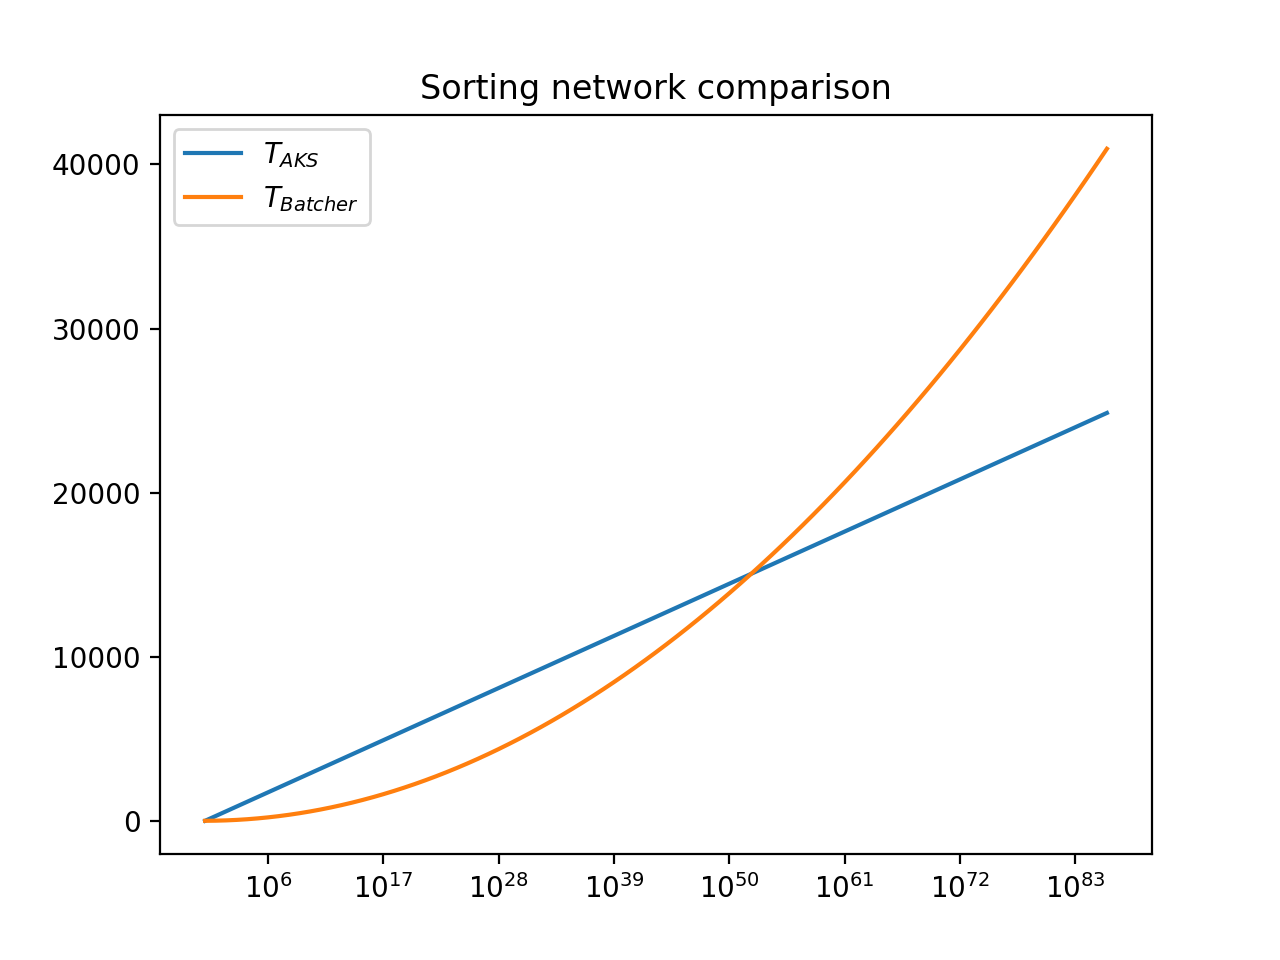

In [8]:
X = [10. ** x for x in range(87)]
T_AKS = [87. * np.log2(x) for x in X]
T_BAT = [0.5 * np.log2(x) * (np.log2 (x) + 1.) for x in X]
plt.figure()
plt.semilogx(X, T_AKS, label='$T_{AKS}$')
plt.semilogx(X, T_BAT, label='$T_{Batcher}$')
plt.title("Sorting network comparison")
plt.legend(loc='best');

## Models in this Class

This class will roughly be organized around the types of machine models that we use.  As the quote above says, one model isn't better than they other, but each has an appropriate scale where it is useful.

### Processors alone

Registers, a scheduler, a functional units

![cpu](images/cpu.jpg)

### Processors and Memory

![ram](images/ram.jpg)

### Processors, Memory, & Cache

![cache](./images/cache.jpg)

### Nodes & Networks

![net](./images/net.jpg)

### Machines & People

![ENIAC](./images/Classic_shot_of_the_ENIAC.jpg)

## Performance Metrics Review

This section is best read along side Georg Hager's [Fooling the Masses]

[Fooling the Masses]: https://blogs.fau.de/hager/archives/category/fooling-the-masses

### Strong Scaling

Assume $\color{OrangeRed}{P}$ describing the machine in $T_{\color{SteelBlue}{f}}(\color{OrangeRed}{P})$ measures its concurrency.

How does $T_{f}(P)$ change as $\color{OrangeRed}{P \to \infty}$?

Some reasonable (but not always true) assumptions:
- $T_{f}(P) = \max_{i} T_{f,i}(P)$, the maximum time spent by any of the parallel components of the machine
- $\max_{i} T_{f,i}(P) \geq
T_{f}(1) / P$.  This is reasonable assuming we start from an efficient serial algorithm. (Why?)
- Therefore
$$\Large T_{f}(P) \geq \color{SeaGreen}{T_{f}(1) / P}.$$  If this is an equality, it is sometimes called <span style='color:SeaGreen'>**perfect strong scaling**</span>.

### Three ways to visualize strong scaling

- $\large T_{f}(P)$ itself: "runtime"
- $\large S_{f}(P) := T_{f}(1) / T_{f}(P)$: "speedup"
- $\large H_{f}(P) := T_{f}(1) / (P T_{f}(P))$: "strong-scaling efficiency"

Why might we prefer to visualize one more than the others?

<IPython.core.display.Javascript object>


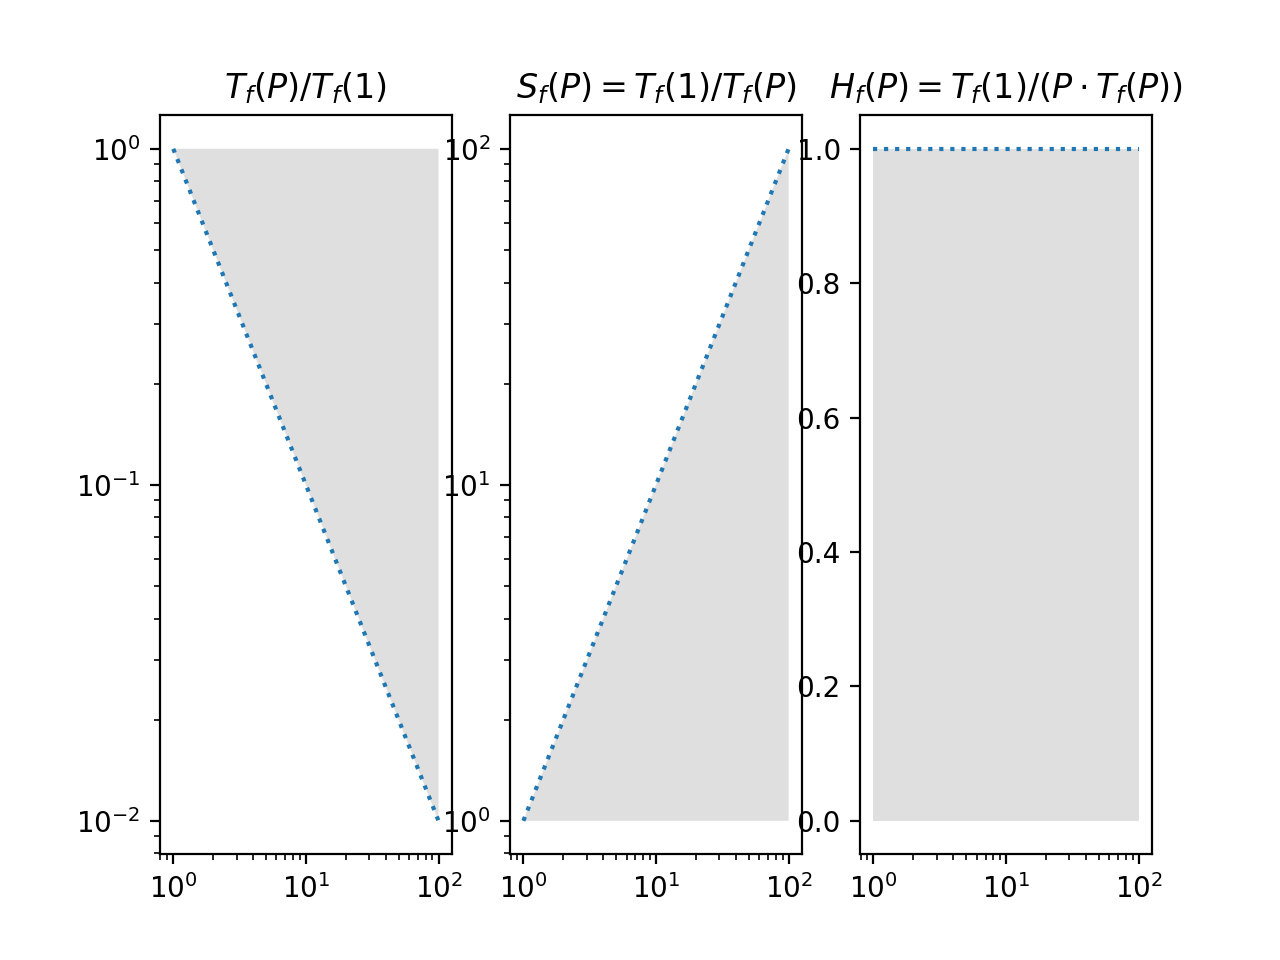

In [10]:
P = np.array(range(1,101))
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.loglog(P,1. / P,':')
ax1.fill_between(P,1. / P, np.ones(100), facecolor='gray', alpha=0.25)
ax1.set_title('$T_f(P) / T_f(1)$')
ax2.loglog(P,P,':')
ax2.fill_between(P,np.ones(100), P, facecolor='gray', alpha=0.25)
ax2.set_title('$S_f(P) = T_f(1) / T_f(P)$')
ax3.semilogx(P,np.ones(100),':')
ax3.fill_between(P,np.zeros(100),np.ones(100), facecolor='gray', alpha=0.25)
ax3.set_title('$H_f(P) = T_f(1) / (P\cdot T_f(P))$');

### Amdahl's Law

Amdahl's law describes strong scalability under the assumption that $T_f(1)$ is composed
of a non-parallelizable fraction $\color{red}{\alpha}$, and a perfectly-parallelizable remainder.

$$\Large T_f(P) = \color{red}{\alpha} T_f(1) + (1 - \color{red}{\alpha}) \frac{T_f(1)}{P}.$$

This implies 

$$\large S_f(P) = \frac{1}{\color{red}{\alpha} + (1 - \color{red}{\alpha})\frac{1}{P}}
\leq \frac{1}{\color{red}{\alpha}}.$$

<IPython.core.display.Javascript object>


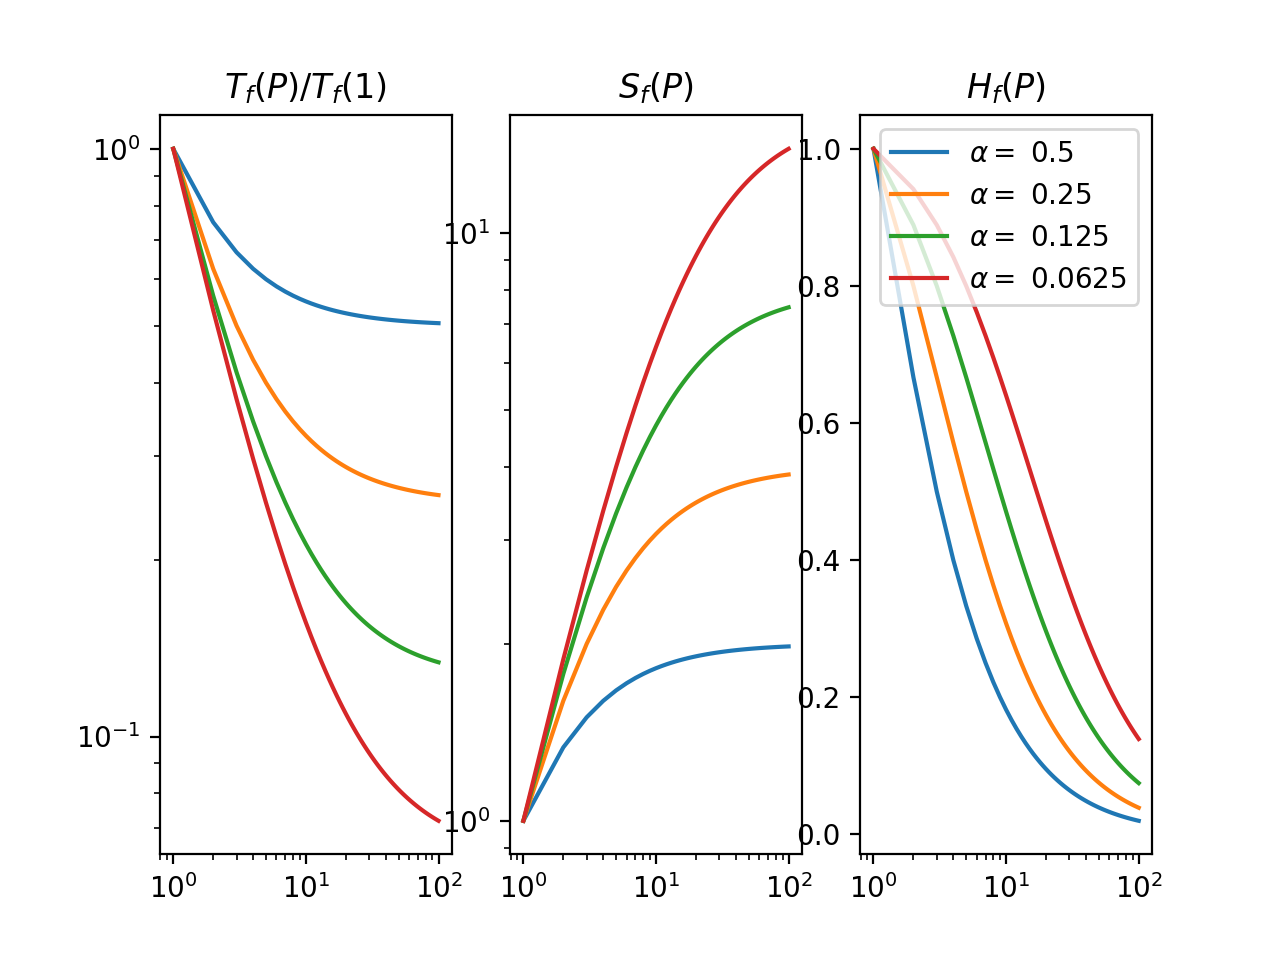

In [11]:
P = np.array(range(1,101))
alpha = [0.5,0.25,0.125,0.0625]
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
for a in alpha:
    T = a + (1.-a) / P
    ax1.loglog(P,T)
    ax2.loglog(P,1./T)
    ax3.semilogx(P,1./(P * T),label='$\\alpha =$ ' +str(a))
ax1.set_title('$T_f(P) / T_f(1)$')
ax2.set_title('$S_f(P)$')
ax3.set_title('$H_f(P)$')
ax3.legend(loc='best');

### Scalability is not Performance

In [12]:
P = range(1,101)
alpha_1 = 0.2
alpha_2 = 0.1 # A smaller serial fraction!
T_1_0 = 1.
T_2_0 = 4. # A less efficient serial algorithm
T_1 = [alpha_1 * T_1_0 + (1. - alpha_1) * T_1_0 / p for p in P]
T_2 = [alpha_2 * T_2_0 + (1. - alpha_2) * T_2_0 / p for p in P]
S_1 = [T_1[0] / T_1[p] for p in range(100)]
S_2 = [T_2[0] / T_2[p] for p in range(100)]

<IPython.core.display.Javascript object>


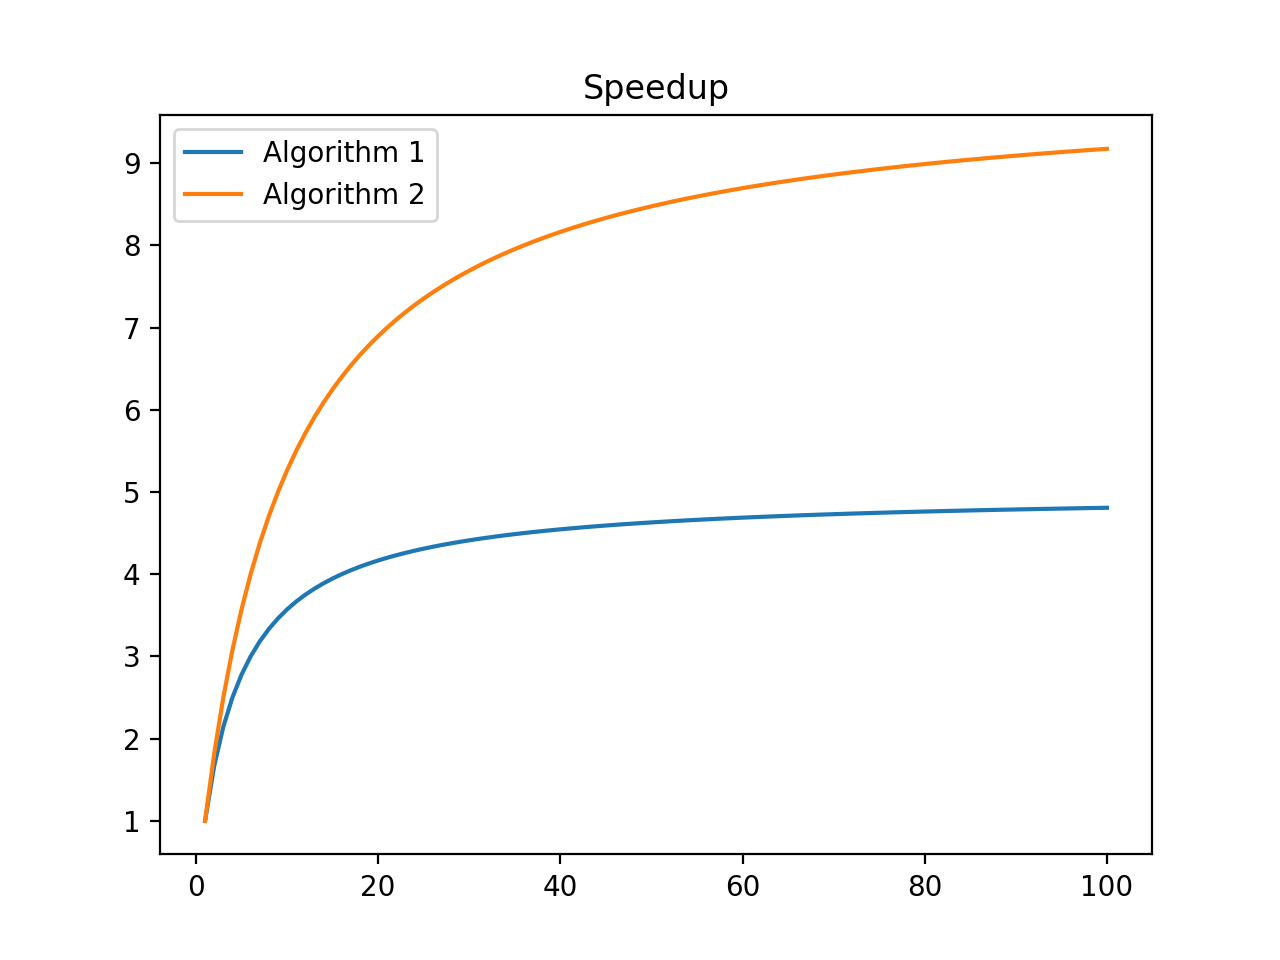

In [13]:
plt.figure()
plt.plot(P,S_1,label="Algorithm 1")
plt.plot(P,S_2,label="Algorithm 2")
plt.title("Speedup")
plt.legend(loc='best');

<IPython.core.display.Javascript object>


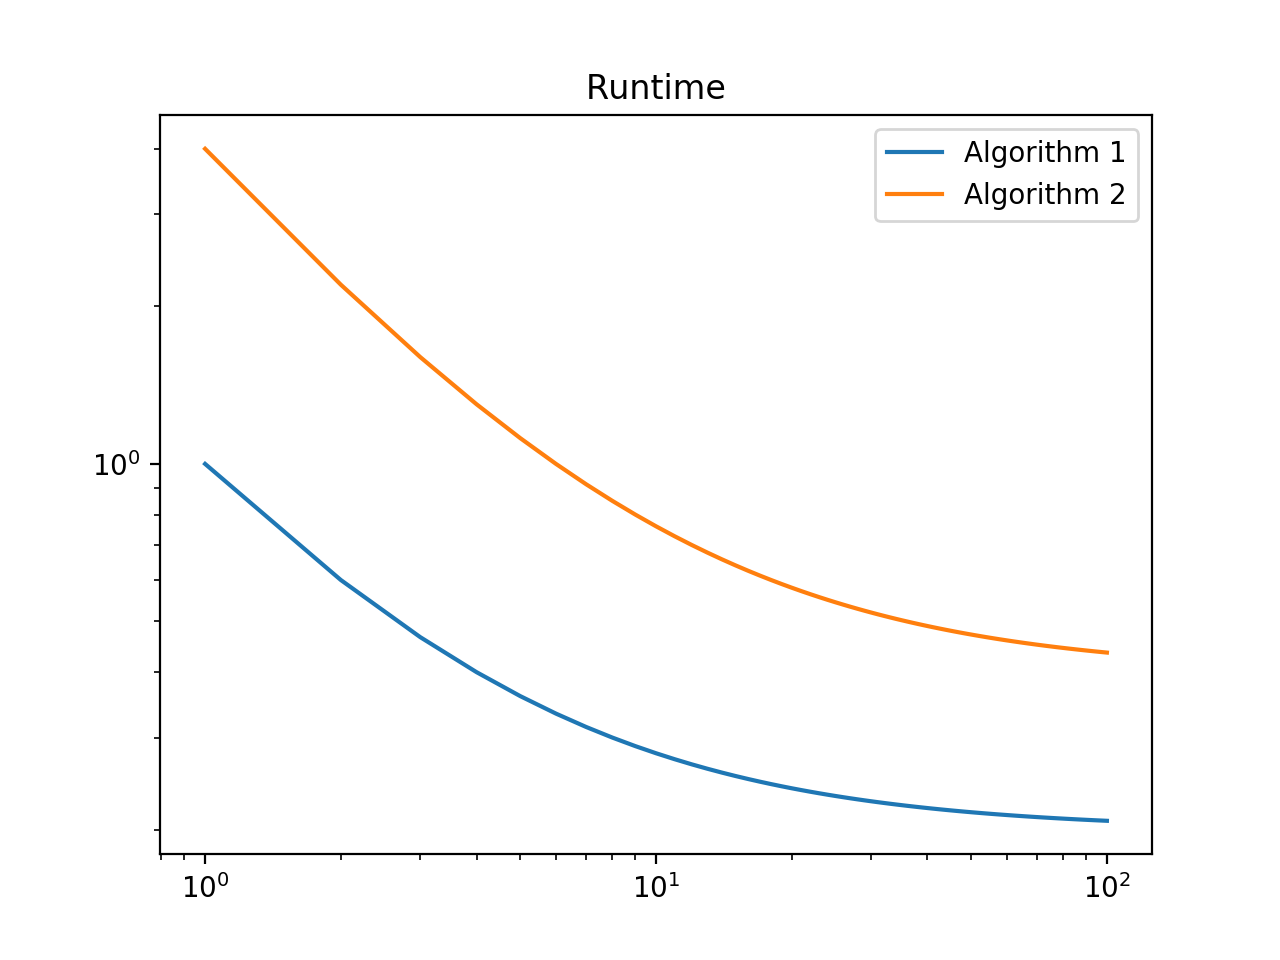

In [14]:
plt.figure()
plt.loglog(P,T_1,label="Algorithm 1")
plt.loglog(P,T_2,label="Algorithm 2")
plt.title("Runtime")
plt.legend(loc='best');

### Weak Scaling

Suppose that our algorithm can be used on a class of problems indexed by their size,
$\color{SeaGreen}{N}$.

$$\LARGE{T_{\color{SteelBlue}{f}} (\color{SeaGreen}{N},\color{OrangeRed}{P})}$$

- By the same assumptions as before $T_f(kN, kP) \geq \frac{1}{k} T_f(kN, P) = \beta T_f (N, P)$,
  where
  
  $$\large \color{red}{\beta = \frac{T_f(kN,P)}{k T_f(N,P)}}.$$
  
- We assume $T_f(N,P) \in \Theta(N)$ (otherwise, under mild assumptions, we can reindex, e.g.,
  if $T_f(N,P) \in \Theta(N^3)$, index by $T_f(\hat{N},P)$, where $\hat{N}:=N^3$)
- This implies $\beta\approx 1$.
- We thus define <span style='color:SeaGreen'>**perfect weak scaling**</span> for this type of problem by

$$\large\color{SeaGreen}{T_f(k N, k P) = T_f (N, P)}.$$

- If we want to talk about weak-scaling for an algorithm whose serial runtime is nonlinear, we can think of weak scaling as **resources that scale with the work of the serial algorithm**.  In this case perfect weak-scaling looks like:

  $$\large \color{red}{P(N) = \alpha T_f(N,1)},$$
  $$\large\color{SeaGreen}{T_f(k N, P(kN)) = T_f (N, P(N))}.$$

The most common ways to visualize weak scaling are, for fixed $N$

- $\large T_f (PN, P)$: "runtime"
- $\large E_f (N, P) = T_f (N, 1) / \large T_f (PN, P)$: "weak-scaling efficiency"

<IPython.core.display.Javascript object>


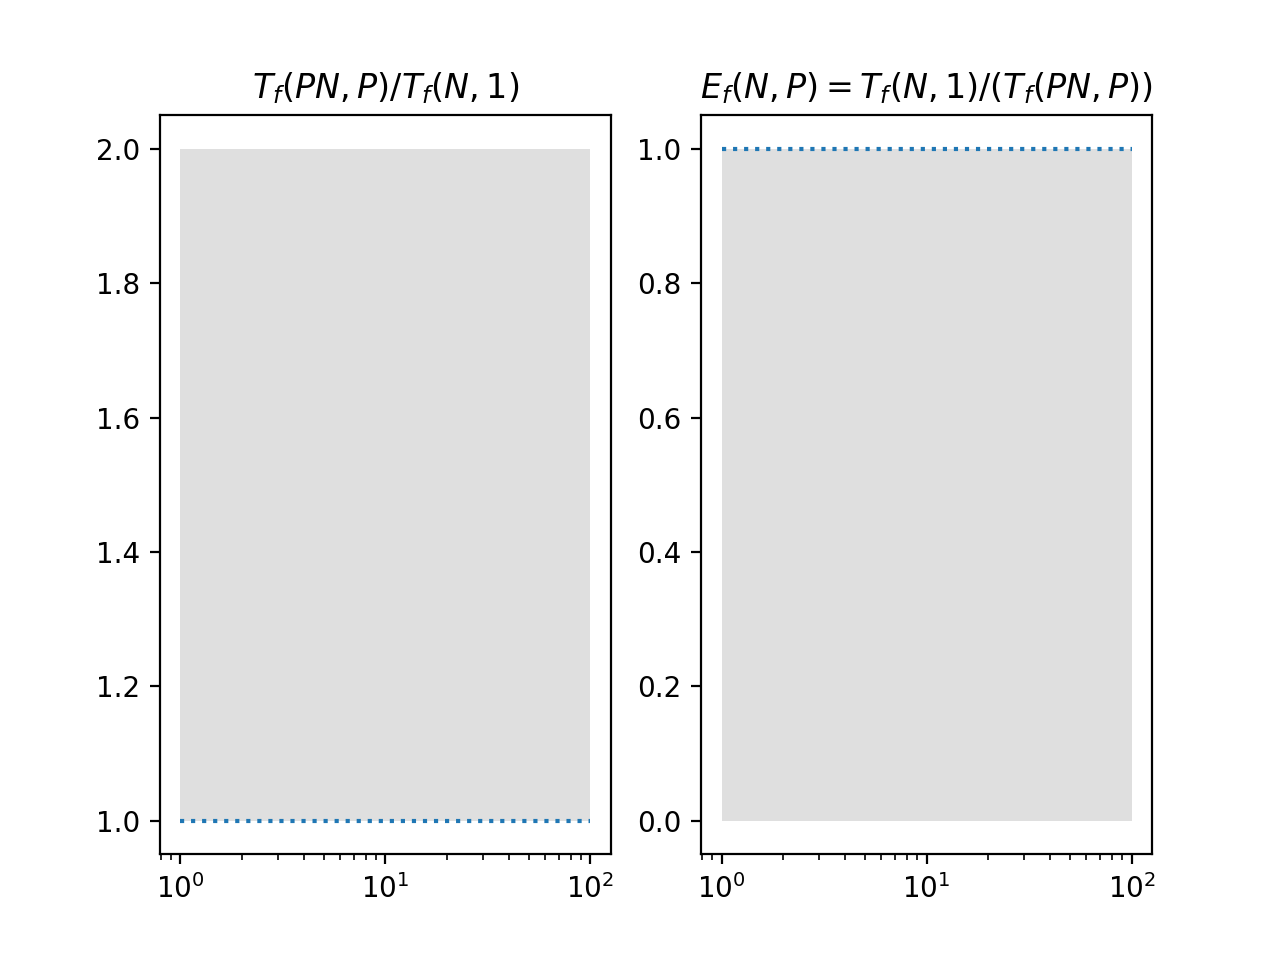

In [17]:
P = np.array(range(1,101))
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.semilogx(P,np.ones(100),':')
ax1.fill_between(P,np.ones(100), 2. * np.ones(100), facecolor='gray', alpha=0.25)
ax1.set_title('$T_f(PN,P) / T_f(N,1)$')
ax2.semilogx(P,np.ones(100),':')
ax2.fill_between(P,np.zeros(100),np.ones(100), facecolor='gray', alpha=0.25)
ax2.set_title('$E_f(N,P) = T_f(N,1) / (T_f(PN,P))$');

### Of course, since $T_f(N,P)$ now has two parameters, should we be suspicious if we only see one line?

Suppose, as is often the case, that *parallelization has overhead*:

$$\large T_f(N,P) = \log P + \frac{N}{P}.$$

<IPython.core.display.Javascript object>


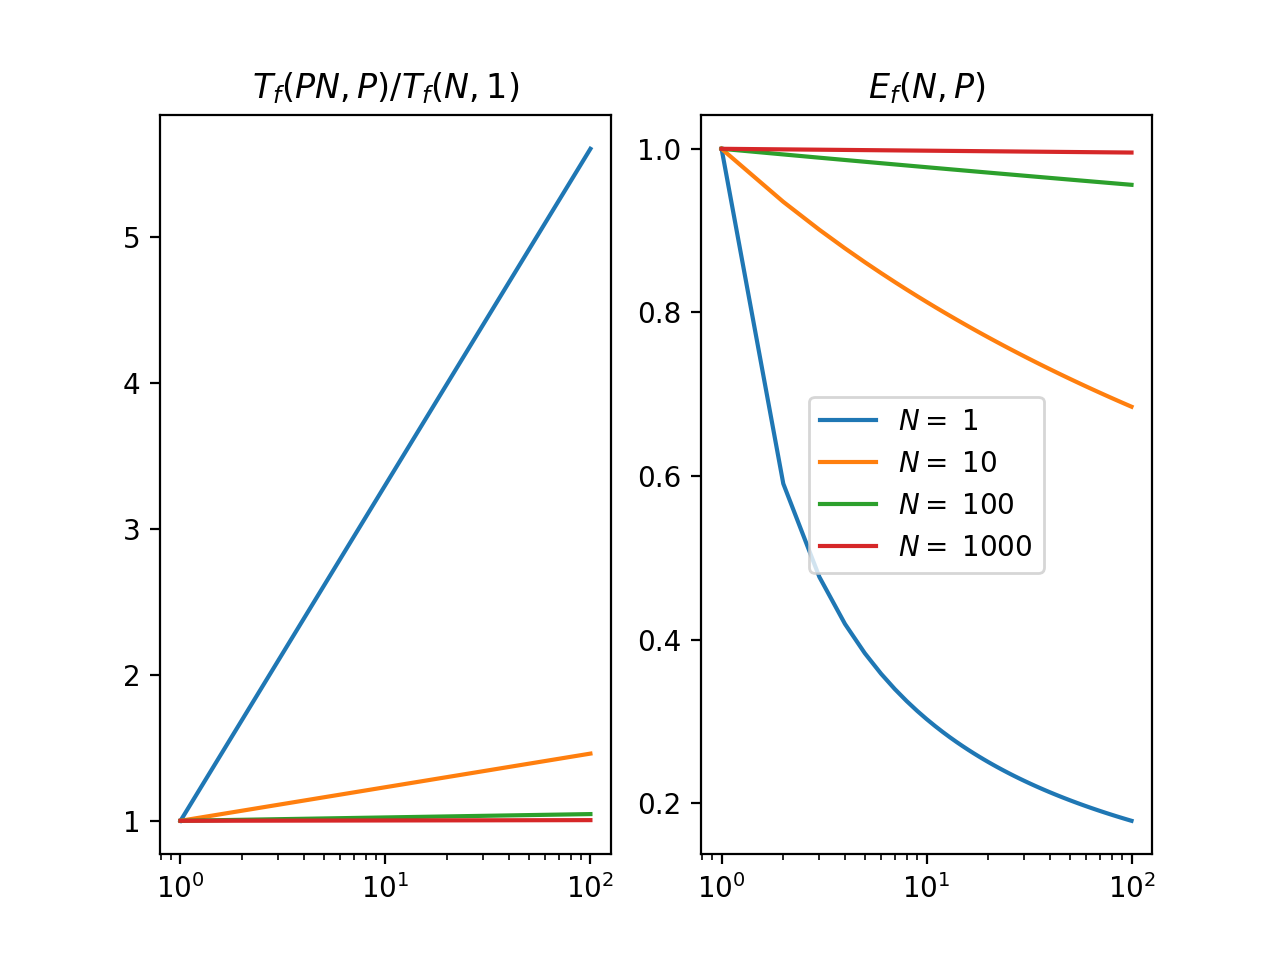

In [18]:
P = np.array(range(1,101))
N = [1, 10, 100, 1000]
f, (ax1, ax2) = plt.subplots(1, 2)
for n in N:
    T = np.log(P) + n
    ax1.semilogx(P,T / T[0])
    ax2.semilogx(P,T[0] /T,label='$N =$ ' +str(n))
ax1.set_title('$T_f(PN,P) / T_f(N,1)$')
ax2.set_title('$E_f(N,P)$')
ax2.legend(loc='best');

### Numerical Algorithms & Error Tolerance

In scientific computing, we often solve problems only approximately, to within some prescribed *error tolerance*:

$$\LARGE{T_{\color{SteelBlue}{f}} (\color{SeaGreen}{N},\color{OrangeRed}{P},\color{Purple}{\epsilon})}$$

- Different numerical methods often have different convergence rates:

$$\large T_{f_1}(N,P,\epsilon) \in O(\epsilon^{-1})$$

$$\large T_{f_2}(N,P,\epsilon) \in O(\epsilon^{-1/2})$$

- But methods with higher convergence rates may not have as much natural concurrency.  It get's complicated,
  and different approaches can be optimal for different parameter sets (see [Pareto optimality](https://en.wikipedia.org/wiki/Pareto_efficiency))

- Two common dual criteria:

  1. Which algorithm and machine can get me $\epsilon_{\max}$ accuracy fastest? 
  
  $$\min_{f,P} T_f(N,P,\epsilon)\text{ such that } \epsilon < \epsilon_{\max}$$
  
  2. Which algorithm and machine minimizes $\epsilon$ for $T_f < T_{\max}$?
  
  $$\min_{f,P} \epsilon\text{ such that } T_f(N,P,\epsilon) < T_{\max}$$

- An interesting recent example of taking all of these things into account: [Chang et al., to appear](https://arxiv.org/pdf/1705.03625.pdf)

### What is common these metrics?

- Of the form: known inputs $\to$ measurable quantities
- They offer to measure different things, because different applications/users *value different things*.
    - Question: what if we care less about time than we do about the energy that went into the computations?  How do the above scalability metrics change?
    - Answer: Very little.  "Time" could be replaced with anything that represents the cost of an algorithm, including energy consumed, or even literal cost ("How much money do I need to spend on $X$ cloud computing service to get my answer?").  The three quantities in $T_f(N,P)$ (time T, problem size N, and number of processes P) can be generalized: we can think of T as some cost that we're trying to minimize, N as some useful work that we want to do, and P as a parameter describing a set of resources that we can use.
    
**If we have a fixed amount of work $N_{target}$ that we want to do:** we use our performance models to find the algorithm/machine combination that minimizes cost:

$$\large \min_{f,P}\ T_f(N_{target},P).$$

**If we have a fixed budget $T_{budget}$:** we use our performance models to find the algorithm/machine combination that maximizes the work done:

$$\large \max_{f,P}\ N \quad \text{subject to}\quad T_f(N,P) \leq T_{target}.$$

## Measuring Performance

### If you've heard of one measurement of performance, it's probably *Flop/s*

- Short for "Floating Point Operations per Second"

- It is a measure of the rate at which a machine is working to solve a problem.

- A measure, not *the* measure

FLOPs is the measure used in ranking the Top500 list:

![top500.org](images/top500.jpg)

- Question: the Top500 list measures a machines flop/s doing *what?*

Answer: computing the [HPLinpack Benchmark](https://en.wikipedia.org/wiki/LINPACK_benchmarks#HPLinpack), i.e.
solving an enormous dense linear system $Ax=b$.

## Okay, so the biggest machines in the world have ~100 Petaflop/s at their disposal

What do we have in this class?

Good question.

## How many flop/s do I have on my laptop?

First, I should find out what kind of processors I have in my laptop.

In [ ]:
%%bash

cat /proc/cpuinfo

Hmm, flop/s are not listed anywhere, but I've determined that I have an `Intel Core i5-7200U` chip.  Now I go over to [ark.intel.com](https://ark.intel.com) to see if Intel will tell me. (The `7` in `7200U` indicates that it is a seventh generation chip)

Hmm, Intel did tell me what the peak frequency of my chip is (3.1 GHz), and how many cores I have (2) but it did not tell me how many flop/s my chip has.  Luckily, they did tell me what the name of my chip was ("Products formerly *Kaby Lake*").

Maybe the kind strangers at [wikipedia:FLOPS](https://en.wikipedia.org/wiki/FLOPS) have some information about Kaby Lake processors for me.

Wikipedia says that my Kaby Lake processor gets 32 single precision floating point instructions per cycle. (That page is not well sourced, but next class we'll talk about where that number comes from).

So, with 2 cores, 32 flop/s per cycle per core, and 3.1 Gigacycles per second,

In [ ]:
2 * 32 * 3.1

So the prediction of this convoluted search was that my laptop can get 198 Gigaflop/s:
I have a $\mu$-top500 machine at my fingertips.

Does that settle it?  Or should we give credence to what I can actually achieve in practice?

That leads us to our first assignment...